# NMIST Multinomial Classifier

Support Vector Machine Classifier and Linear Classifier are strictly Binary
Whereas Random Forest Classifier, naive Bayes Classifiers or Stochastic Gradient Descent can handle multiple classes

Strategies can allow for binary classifiers to handle  mutiple classes such as one-versus-all (OvA) or one-versus-one (OvO)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(42)

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST Original')
X,y = mnist['data'], mnist['target']
some_digit = X[36000]

In [3]:
# we split the into two 60000 for train and 10000 for test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# then we shuffle everything
shuffle = np.random.permutation(60000)
X_train, y_train = X_train[shuffle], y_train[shuffle]

In [4]:
#under the hood sklearn actually trains 10 binary classifiers (OvO)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\charles.fried\AppData\Local\Continuum\Anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 5.])

In [5]:
# as  a proof when asked for the score sklearn returns 10 scores
some_digit_scores = sgd_clf.decision_function([some_digit])
print('The winner is: ', np.argmax(some_digit_scores))

The winner is:  5


In [6]:
# we can force a OvO or OvA by using OneVsOneClassifier or OneVsRestClassifier classes and passing a binary classifier
# to its constructor

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\charles.fried\AppData\Local\Continuum\Anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 5.])

In [7]:
# we can do the same with a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [8]:
# we can evaluate the model using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.84063187,  0.84899245,  0.86652998])

In [9]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.90796841,  0.91494575,  0.91383708])

In [10]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.94041192,  0.93879694,  0.93949092])

In [11]:
# performance can be improved by scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))


In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [13]:
# in order to further tune our model let's get the confusion matrix

from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]], dtype=int64)

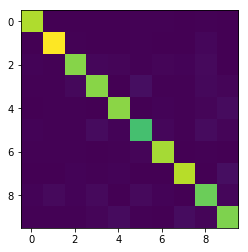

In [14]:
# it's often more helpful to look at it as an image
# we can see either our network is having a hard time classifying 5's or there's less of them
plt.imshow(conf_mx)

# remember that the rows represent the actual class while the columns represent the predicted class

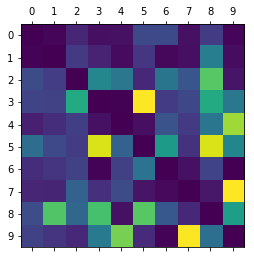

In [15]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # we take the sum of each number (rows)
norm_conf_mx = conf_mx / row_sums # we then divide each number by the total of instances
np.fill_diagonal(norm_conf_mx, 0) # then we fill the diagonals with zero's to keep only the errors
plt.matshow(norm_conf_mx)
plt.xticks(np.arange(10));
plt.yticks(np.arange(10));

In [16]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

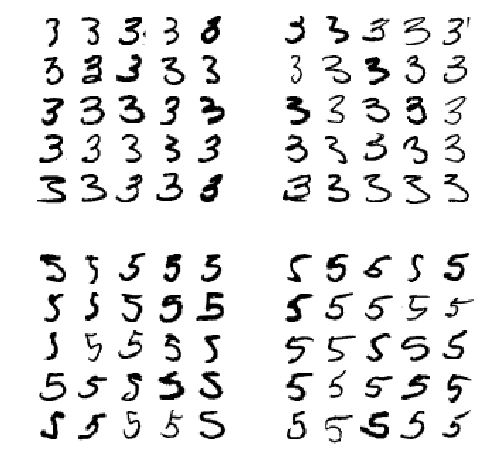

In [17]:
# the major error is classifying 3's as 5's so let's plot them
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# digits on the left are classified as 3's and on the right as 3's

## Multilabel Classification
Say we want to detect more than one person in a picture

In [18]:
# KNeighborsClassifier supports multi class classification
from sklearn.neighbors import KNeighborsClassifier

# this creates an array containing two labels one of 7, 8 & 9's and the orther odd numbers
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [19]:
# we can make a predicion - it is correct 5 is isn't larger than 7 but it is an odd number
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [20]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average='micro')

KeyboardInterrupt: 

## Multioutput Classification
This builds onto the previous case where we might have more than one class for each label
Note: In this instance the line between classification and regression. Sometimes we might want our algorithm to predict both a class label and a value label.

In this example we'll add noise to the pictures and then train a classifier to clean them.

In [23]:
# we train a KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

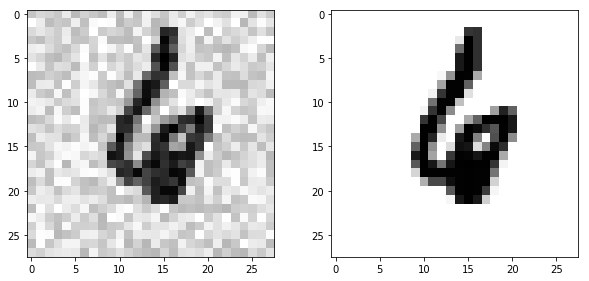

In [22]:
# we add the noise to the images and the target are the originals

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(X_train_mod[2].reshape(28, 28), cmap = matplotlib.cm.binary)
plt.subplot(222)
plt.imshow(X_train[2].reshape(28, 28), cmap = matplotlib.cm.binary)

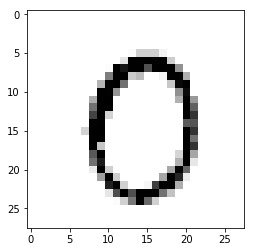

In [24]:
# it outputs a clean prediction
clean_digit = knn_clf.predict([X_test_mod[2]])
plt.imshow(clean_digit.reshape(28, 28), cmap = matplotlib.cm.binary)